**Examples**

Baseball

In [45]:
try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint

from pint import UnitRegistry
units = UnitRegistry()

In [46]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [47]:
from modsim import *

Vectors

In [48]:
A = Vector(3, 4)
show(A)

,component
x,3
y,4


In [49]:
print(A.x)
print(A.y)
print(A[0])
print(A[1])

3
4
3
4


In [50]:
B = Vector(1, 2)
print(show(A + B))
print(show(A - B))

   component
x          4
y          6
   component
x          2
y          2


In [54]:
from numpy import rad2deg
from numpy import deg2rad
mag = vector_mag(A)
theta = vector_angle(A)
angle = rad2deg(theta)
theta = deg2rad(angle)
print(mag, theta)
print(angle)
print(theta)

5.0 0.9272952180016122
53.13010235415598
0.9272952180016122


In [55]:
x, y = pol2cart(theta, mag)
C = Vector(x, y)
print(show(C))
print(show(A / vector_mag(A)))
A_hat = vector_hat(A)
print(show(A_hat))

   component
x        3.0
y        4.0
   component
x        0.6
y        0.8
   component
x        0.6
y        0.8


Simulating Baseball Flight

In [58]:
params = Params(    #All units
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s
    mass = 145e-3,    # kg
    diameter = 73e-3, # m
    C_d = 0.33,       # dimensionless
    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,     # s
)

In [59]:
from numpy import pi, deg2rad
def make_system(params):

    # convert angle to radians
    theta = deg2rad(params.angle)
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

In [60]:
system = make_system(params)
show(system.init)

,state
x,0.000000
y,1.000000
vx,28.284271
vy,28.284271


Drag Force

In [61]:
def df(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = df(V_test, system)
show(f_drag)

,component
x,-0.937574
y,-0.937574


In [62]:
def sf(t, state, system):

    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = df(V, system) / mass
    a_grav = g * Vector(0, -1)
    A = a_grav + a_drag

    return V.x, V.y, A.x, A.y
sf(0, system.init, system)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

Adding an Event Function

In [63]:
def ef(t, state, system):
    x, y, vx, vy = state
    return y
ef(0, system.init, system)

1.0

In [64]:
results, details = run_solve_ivp(system, sf, events=ef)
details.message

'A termination event occurred.'

In [65]:
results.tail()

,x,y,vx,vy
4.804692,96.438515,4.284486,14.590855,-20.726780
4.854740,97.166460,3.238415,14.484772,-21.065476
4.904789,97.889087,2.175515,14.378566,-21.400392
4.954838,98.606374,1.095978,14.272264,-21.731499
5.004887,99.318296,0.000000,14.165894,-22.058763


In [66]:
flight_time = results.index[-1]
flight_time

5.004887034868346

In [67]:
final_state = results.iloc[-1]
show(final_state)

,5.004887
x,99.318296
y,0.000000
vx,14.165894
vy,-22.058763


In [68]:
first_distance = final_state.x
first_distance

99.31829628352207

In [69]:
final_V = Vector(final_state.vx, final_state.vy)
show(final_V)

,component
x,14.165894
y,-22.058763


In [70]:
vector_mag(final_V)

26.215674453237572

Visualizing Trajectories

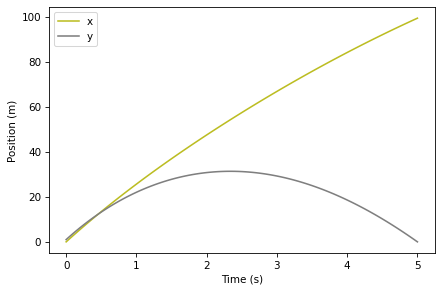

In [71]:
results.x.plot(color='C8')
results.y.plot(color='C7', style='-')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

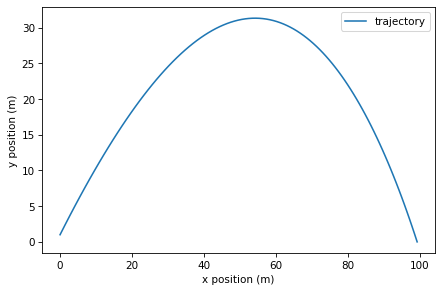

In [72]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

In [73]:
rad2deg(vector_angle(final_V))

-57.29187097821225

Animating the Baseball

In [74]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()
def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

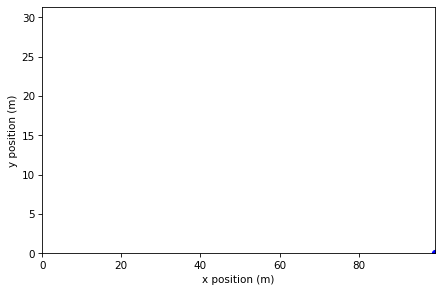

In [26]:
animate(results, draw_func)

**Exercises**

Exercise 1

In [75]:
system2 = make_system(params.set(C_d=0))
results2, details2 = run_solve_ivp(system2, sf, events=ef)
details.message

'A termination event occurred.'

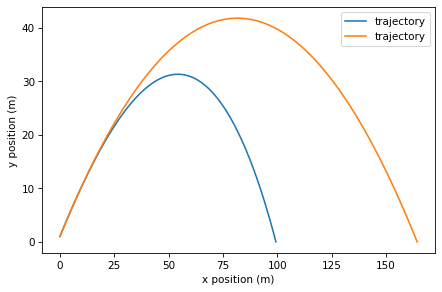

In [76]:
plot_trajectory(results)
plot_trajectory(results2)

In [77]:
second_distance = results2.iloc[-1].x
second_distance

164.2592550241319

In [78]:
second_distance - first_distance

64.94095874060983

Exercise 2

In [79]:
system3 = make_system(params.set(rho=1.0))
results3, details3 = run_solve_ivp(system3, sf, events=ef)

first_distance3 = results3.iloc[-1].x
first_distance3

105.78838005859785

In [80]:
first_distance3 - first_distance

6.4700837750757785

Exercise 3

In [81]:
def df2(V, system):

    rho, area = system.rho, system.area
    C_d = drag_interp(vector_mag(V))
    mag = -rho * vector_mag(V)**2 * C_d * area / 2
    direction = vector_hat(V)
    f_drag = direction * mag

    return f_drag

def sf2(t, state, system):

    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = df2(V, system) / mass
    a_grav = g * Vector(0, -1)
    A = a_grav + a_drag

    return V.x, V.y, A.x, A.y

system4 = make_system(params)

V = Vector(30, 30)
f_drag = df(V, system4)

show(f_drag)

,component
x,-1.054771
y,-1.054771


In [82]:
sf(0, system4.init, system4)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)